# Intro

This is for preprocess dataset. There are steps we have:

Segmentation

1. copy recordings and put them under one single folder
2. extract phrase for all recordings (exclude tone sandhi)
3. create TG for every recording
4. do mfa, get segmented tiers (use pinyin based dict)
5. get st and ed time for each syllable
6. chop long recording into syllables


Audio preprocess

1. convert audios from wave to mel_spectrogram
2. convert audios from wave to spectrogram
3. globally normalize (mel-)spectrogram
4. filter sound then do transformation

# Segmentation

##  Reorganize folder

In [1]:
import os
import shutil
import pandas as pd

In [ ]:
sourcefolder = "/mnt/storage/compling/proslearn/src/man_tone/train/wav"
targetfolder = "/mnt/storage/compling/proslearn/src/man_tone/corpus_mfa"
alignedfolder = "/mnt/storage/compling/proslearn/src/man_tone/corpus_aligned_tg"

In [ ]:
for folder, subfolders, files in os.walk(sourcefolder):
    for file in files:
        #shutil.copy(os.path.join(folder, file),targetfolder)
    
        #tgfile = os.path.join(targetfolder, file).replace(".wav", ".TextGrid")
        #shutil.copy(tgfile,folder)
        
        aligned_tgfile = os.path.join(alignedfolder, file).replace(".wav", ".TextGrid")
        try:
            shutil.copy(aligned_tgfile,folder)
        except Exception as e:
            print(e)
## 88035 sentences: test set: 24773; train set: 63262

## Extract pinyin phrases

In [ ]:
train_label_file = pd.read_csv("/mnt/storage/compling/proslearn/src/man_tone/train/content.txt",sep="\\t",header=None)
test_label_file = pd.read_csv("/mnt/storage/compling/proslearn/src/man_tone/test/content.txt",sep="\\t",header=None)

In [ ]:
df_sorted_test = pd.DataFrame(columns=["original_filename","phrase_chinese","phrase_pinyin"])

for index,row in test_label_file.iterrows():
    filename = row[0]
    temp = row[1].split(" ")
    odd_index_values = temp[1::2]
    even_index_values = temp[0::2]
    phrase_chinese = " ".join(even_index_values)
    phrase_pinyin = " ".join(odd_index_values)
    new_row = pd.DataFrame([{"original_filename":filename,"phrase_chinese":phrase_chinese,"phrase_pinyin":phrase_pinyin}])
    df_sorted_test = df_sorted_test._append(new_row,ignore_index=True)

In [ ]:
df_sorted_test.to_csv("/mnt/storage/compling/proslearn/src/man_tone/label_test.csv")

In [ ]:
df_sorted_test['speaker'] = df_sorted_test['original_filename'].apply(lambda x: x[:7])
df_sorted_test['original_filepath'] = df_sorted_test['original_filename'].apply(lambda x: os.path.join("/mnt/storage/compling/proslearn/src/man_tone/test/wav",x[:7],x))
df_sorted_test.to_csv("/mnt/storage/compling/proslearn/src/man_tone/label_test.csv")

In [ ]:
df_sorted_train = pd.DataFrame(columns=["original_filename","phrase_chinese","phrase_pinyin"])

for index,row in train_label_file.iterrows():
    filename = row[0]
    temp = row[1].split(" ")
    odd_index_values = temp[1::2]
    even_index_values = temp[0::2]
    phrase_chinese = " ".join(even_index_values)
    phrase_pinyin = " ".join(odd_index_values)
    new_row = pd.DataFrame([{"original_filename":filename,"phrase_chinese":phrase_chinese,"phrase_pinyin":phrase_pinyin}])
    df_sorted_train = df_sorted_train._append(new_row,ignore_index=True)

In [ ]:
df_sorted_train.to_csv("/mnt/storage/compling/proslearn/src/man_tone/label_train.csv")

In [ ]:
df_sorted_train['speaker'] = df_sorted_train['original_filename'].apply(lambda x: x[:7])
df_sorted_train['original_filepath'] = df_sorted_train['original_filename'].apply(lambda x: os.path.join("/mnt/storage/compling/proslearn/src/man_tone/train/wav",x[:7],x))
df_sorted_train.to_csv("/mnt/storage/compling/proslearn/src/man_tone/label_train.csv")

## Generated TextGrid

use the genreateBlankTG.praat and labelPhraseTier.praat

## Use Montreal Forced Aligner

## Extract syllables
-use choprecording.praat

In [ ]:
df_sorted_test = pd.read_csv("/mnt/storage/compling/proslearn/src/man_tone/label_test.csv")
df_sorted_train = pd.read_csv("/mnt/storage/compling/proslearn/src/man_tone/label_train.csv")

## Prepare Metadata

In [ ]:
meta_test = []
for index, row in df_sorted_test.iterrows():
    original_filepath = row['original_filepath']
    chop_txt = original_filepath.replace(".wav",".txt")
    chop_infor = pd.read_csv(chop_txt,sep="\t",encoding="utf-16")
    try:
        chop_infor['syllable_pinyin'] = row["phrase_pinyin"].split(" ")
        chop_infor["tone_type"] = chop_infor["syllable_pinyin"].apply(lambda x: x[-1])
    except:
        continue
    for jndex, rowj in chop_infor.iterrows():
        syllable_filename = rowj["syllabel_filename"]
        syllable_filepath = rowj["syllabel_filepath"]
        syllable_chinese = rowj["syllable_chinese"]
        syllable_pinyin = rowj["syllable_pinyin"]
        new_path = syllable_filepath.replace(syllable_chinese,syllable_pinyin)
        rowj['syllable_filename'] = syllable_filename.replace(syllable_chinese,syllable_pinyin)
        rowj['syllable_filepath'] = new_path
        if os.path.exists(new_path) is False:
            os.rename(syllable_filepath,new_path)
        row_dict = dict(rowj)
        meta_test.append(row_dict)


In [ ]:
meta_test = pd.DataFrame(meta_test)
meta_test = meta_test.drop("syllabel_filename",axis=1)
meta_test = meta_test.drop("syllabel_filepath",axis=1)
meta_test['suid'] = meta_test['syllable_filename'].apply(lambda x: x.replace(".wav",""))
meta_test["stress_type"] = meta_test["tone_type"]
meta_test = meta_test.rename(columns={"syllable_filepath":"syllable_path"})
meta_test.to_csv(f"/mnt/storage/compling/proslearn/src/man_tone/test/meta_test.csv")

In [ ]:
meta_train = []
for index, row in df_sorted_train.iterrows():
    original_filepath = row['original_filepath']
    chop_txt = original_filepath.replace(".wav",".txt")
    chop_infor = pd.read_csv(chop_txt,sep="\t",encoding="utf-16")
    try:
        chop_infor['syllable_pinyin'] = row["phrase_pinyin"].split(" ")
        chop_infor["tone_type"] = chop_infor["syllable_pinyin"].apply(lambda x: x[-1])
    except:
        continue
    for jndex, rowj in chop_infor.iterrows():
        syllable_filename = rowj["syllabel_filename"]
        syllable_filepath = rowj["syllabel_filepath"]
        syllable_chinese = rowj["syllable_chinese"]
        syllable_pinyin = rowj["syllable_pinyin"]
        new_path = syllable_filepath.replace(syllable_chinese,syllable_pinyin)
        rowj['syllable_filename'] = syllable_filename.replace(syllable_chinese,syllable_pinyin)
        rowj['syllable_filepath'] = new_path
        if os.path.exists(new_path) is False:
            os.rename(syllable_filepath,new_path)
        row_dict = dict(rowj)
        meta_train.append(row_dict)

In [ ]:
meta_train = pd.DataFrame(meta_train)
meta_train['suid'] = meta_train['syllable_filename'].apply(lambda x: x.replace(".wav",""))
meta_train["stress_type"] = meta_train["tone_type"]
meta_train = meta_train.rename(columns={"syllable_filepath":"syllable_path"})
meta_train.to_csv(f"/mnt/storage/compling/proslearn/src/man_tone/train/meta_train.csv")

# Audio Process

In [1]:
import os
import numpy as np
import audioPreprocess as ap
import random
import dataPreprocess as dp
import pandas as pd
import librosa
import soundfile as sf

## prepare meta data

In [67]:
## set parameters
## there are three csv files that need to be processed; guide_train.csv, guide_test.csv,guide_validation.csv
set = "train"
soundfolder = f"/mnt/storage/compling/proslearn/src/man_tone/{set}/wav"# where original sound files are stored
meta_path = f"/mnt/storage/compling/proslearn/src/man_tone/{set}/meta_{set}.csv"  
labelfile_path = f"/mnt/storage/compling/proslearn/src/man_tone/label_{set}.csv"  

In [68]:

## define result files' names
padded_waves_folder = soundfolder.replace('wav','padded_wavs')
highpass_spectrogram_folder = soundfolder.replace('wav','highpass_spectrograms')
lowpass_spectrogram_folder = soundfolder.replace('wav','lowpass_spectrograms')
mel_folder = soundfolder.replace('wav','mels')
spectrogram_folder = soundfolder.replace('wav','spectrograms')
lowpass_mel_folder = soundfolder.replace('wav','lowpass_mels')
highpass_mel_folder = soundfolder.replace('wav','highpass_mels')
lowpass_padded_waves_folder = soundfolder.replace('wav','lowpass_padded_wavs')
highpass_padded_waves_folder = soundfolder.replace('wav','highpass_padded_wavs')


In [69]:

os.makedirs(padded_waves_folder, exist_ok=True)
os.makedirs(highpass_padded_waves_folder, exist_ok=True)
os.makedirs(lowpass_padded_waves_folder, exist_ok=True)
os.makedirs(spectrogram_folder, exist_ok=True)
os.makedirs(mel_folder, exist_ok=True)
os.makedirs(lowpass_spectrogram_folder, exist_ok=True)
os.makedirs(highpass_spectrogram_folder, exist_ok=True)
os.makedirs(lowpass_mel_folder, exist_ok=True)
os.makedirs(highpass_mel_folder, exist_ok=True)

In [70]:
test_data = pd.read_csv(meta_path)
sound, sr = ap.load_file(test_data['syllable_path'][0])
# sr = 44100
label_file = pd.read_csv(labelfile_path)
label_file = label_file.drop(label_file.columns[0], axis=1)
test_data = pd.merge(test_data, label_file, on='original_filename')
test_data = test_data[['original_filename','original_filepath','phrase_chinese','phrase_pinyin','position','speaker','stress_type',
                       'suid','syllable_filename','syllable_chinese','syllable_pinyin','tone_type','syllable_path']]
test_data.to_csv(meta_path, index=False)

## waveforms

### padded waves

In [71]:
meta_data = pd.read_csv(meta_path)

In [72]:
def padder_waveform(sound, sample_rate=44100, pad_len_ms=250, noise_level=0.001) -> np.ndarray:
    '''
    Random pad a waveform (mono) to fixed length
    :param sound: waveform
    :param sample_rate:
    :param pad_len_ms: target length of padded waveform
    :param noise_level: the sound will be padded with noise
    :return: padded waveform
    '''
    pad_len_frame = sample_rate // 1000 * pad_len_ms
    sound_len = len(sound)
    if sound_len > pad_len_frame:
        try:
            sig = sound[:pad_len_frame]
        except:
            print(sound)
            print(pad_len_frame)
            input()

    elif sound_len < pad_len_frame:
        # Length of padding to add at the beginning and end of the signal
        pad_begin_len = random.randint(0, pad_len_frame - sound_len)
        pad_end_len = pad_len_frame - sound_len - pad_begin_len

        # Pad with 0s
        # pad_begin = torch.zeros((num_rows, pad_begin_len))
        # pad_end = torch.zeros((num_rows, pad_end_len))
        pad_begin = np.random.randn(pad_begin_len) * noise_level
        pad_end = np.random.randn(pad_end_len) * noise_level

        sig = np.concatenate((pad_begin, sound, pad_end))
    else:
        sig =sound
    return sig

In [73]:
# pad waves
padded_wave_paths = []
for index,row in meta_data.iterrows():
    syllable_path = row['syllable_path']
    wav = ap.load_file(syllable_path)[0]
    padded_wav = padder_waveform(wav,sample_rate=sr,pad_len_ms=250,noise_level=1e-4)
    subfolder = os.path.join(padded_waves_folder,row['speaker'])
    if os.path.exists(subfolder) is False:
        os.makedirs(subfolder)
    # Save the NumPy array as a WAV file using librosa
    output_file = os.path.join(subfolder,row['syllable_filename']).replace(".wav","_padded.wav")
    if os.path.exists(output_file) is False:
        sf.write(output_file, padded_wav, sr)
    padded_wave_paths.append(output_file)

In [74]:
meta_data['padded_wav_path'] = padded_wave_paths

## waveform to (mel-)spectrogram

si1


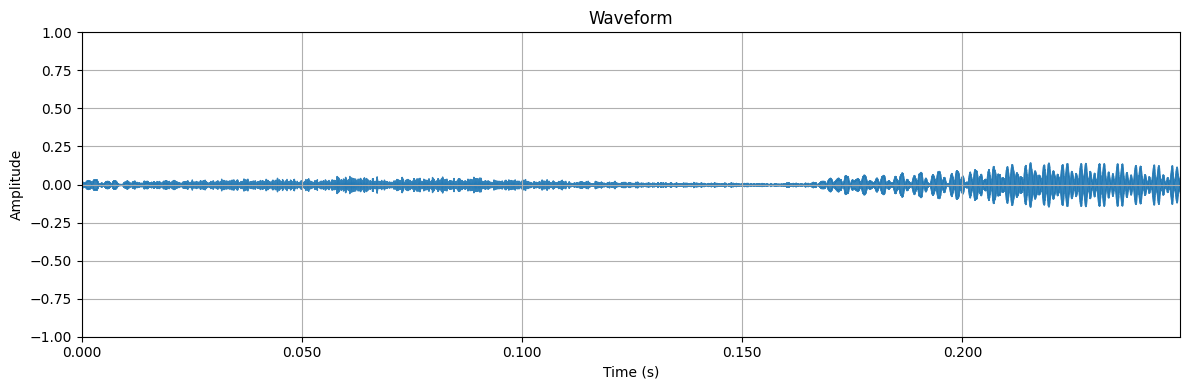

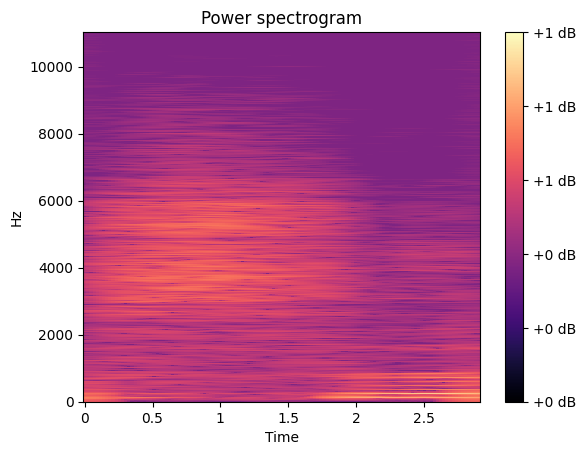

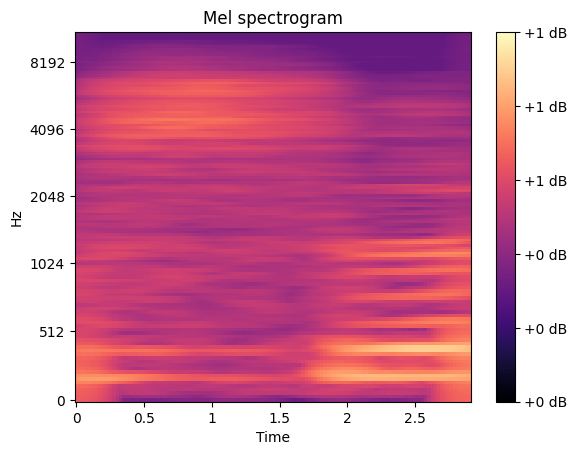

In [75]:
# this is a single process sample
seed = random.randint(0,len(meta_data))
sample = meta_data.iloc[seed]
padded_wav_path = sample['padded_wav_path']
syllable = sample['syllable_pinyin']
sound,sr = ap.load_file(padded_wav_path)
print(syllable)
ap.visualize_waveform(sound,sr)
spectrogram = ap.wav_to_spectrogram(sound,n_fft = int((1024/16000)*sr),hop_length = int((32/16000)*sr))
spectrogram = dp.fixed_min_max_normalization(spectrogram,min = -6, max = 147)
ap.visualize_spectrogram(spectrogram)
mel = ap.wav_to_mel_spectrogram(sound,sr,n_fft = int((1024/16000)*sr),hop_length = int((32/16000)*sr))
mel = dp.fixed_min_max_normalization(mel,min = -6, max = 128)
ap.visualize_mel(mel)

In [76]:
meta_data['spectrogram_path'] = meta_data.apply(lambda row: os.path.join(spectrogram_folder, row['speaker'],row['suid']+"_spectrogram.npy"), axis=1)
meta_data['mel_path'] = meta_data.apply(lambda row: os.path.join(mel_folder, row['speaker'],row['suid']+"_mel.npy"), axis=1)
#dp.save_dataset(test_data,meta_path)

print(os.path.dirname(meta_data['spectrogram_path'][4]))
print(meta_data['mel_path'][4])

/mnt/storage/compling/proslearn/src/man_tone/train/spectrograms/SSB0005
/mnt/storage/compling/proslearn/src/man_tone/train/mels/SSB0005/SSB00050001_5_xue2_mel.npy


In [77]:
meta_data.to_csv(meta_path,index =False)

### Normalization Pretest

In [ ]:

import numpy as np

# Parameters
sample_rate = sr  # Samples per second
duration = 0.25       # Duration in seconds
## check ceiling and floor for spectrogram
chunk_size = 5000
spec_max_dB = None
spec_min_dB =  None
mel_max_dB = None
mel_min_dB = None
# Process in chunks
for seed in range(0, len(meta_data)):
    if seed % 10000 == 0:
        print("seed: ",seed)
    sample = meta_data.iloc[seed]
    padded_wav_path = sample['padded_wav_path']
    syllable = sample['syllable_pinyin']
    sound,sr = ap.load_file(padded_wav_path)
    spectrogram = ap.wav_to_spectrogram(sound,n_fft = int((1024/16000)*sr),hop_length = int((32/16000)*sr))
    
    spectrogram = np.array(spectrogram)
    spec_temp_max = np.max(spectrogram)
    spec_temp_min = np.min(spectrogram)
    mel = ap.wav_to_mel_spectrogram(sound,sr = sr,n_fft = int((1024/16000)*sr),hop_length = int((32/16000)*sr))
    mel = np.array(mel)
    mel_temp_max = np.max(mel)
    mel_temp_min = np.min(mel)
    if spec_max_dB is None or spec_temp_max > spec_max_dB:
        spec_max_dB = spec_temp_max
        print("temp spec max:",spec_temp_max)
    if mel_max_dB is None or mel_temp_max > mel_max_dB:
        mel_max_dB = mel_temp_max 
        print("temp mel max:", spec_temp_min)
    if spec_min_dB is None or spec_temp_min < spec_min_dB:
        spec_min_dB = spec_temp_min
        print("temp spec min", spec_temp_min)
    if mel_min_dB is None or mel_temp_min < mel_min_dB:
        mel_min_dB = mel_temp_min   
        print("temp mel min", mel_temp_min)
print(spec_max_dB,spec_min_dB,mel_max_dB,mel_min_dB)

In [78]:
spec_max_dB = 147.81421 
spec_min_dB =  -6.0206075
mel_max_dB = 134.04613
mel_min_dB = 7.907195

In [79]:

for seed in range(0, len(meta_data)):
    if seed % 10000 == 0:
        print("seed: ",seed)
    sample = meta_data.iloc[seed]
    padded_wav_path = sample['padded_wav_path']
    syllable = sample['syllable_pinyin']
    sound,sr = ap.load_file(padded_wav_path)
    spectrogram = ap.wav_to_spectrogram(sound,n_fft = int((1024/16000)*sr),hop_length = int((32/16000)*sr))
    
    spectrogram = np.array(spectrogram)
    spectrogram = dp.fixed_min_max_normalization(spectrogram,min = spec_min_dB, max = spec_max_dB)
    mel = ap.wav_to_mel_spectrogram(sound,sr = sr,n_fft = int((1024/16000)*sr),hop_length = int((32/16000)*sr))
    mel = np.array(mel)
    mel = dp.fixed_min_max_normalization(mel,min=mel_min_dB,max=mel_max_dB) 
    spec_subfolder = os.path.dirname(sample['spectrogram_path'])
    if os.path.exists(spec_subfolder) is False:
        os.makedirs(spec_subfolder)
    
    mel_subfolder = os.path.dirname(sample['mel_path'])
    if os.path.exists(mel_subfolder) is False:
        os.makedirs(mel_subfolder)
    np.save(file = sample['spectrogram_path'], arr = spectrogram)
    np.save(file = sample['mel_path'], arr = mel)

seed:  0
seed:  10000
seed:  20000
seed:  30000
seed:  40000
seed:  50000
seed:  60000
seed:  70000
seed:  80000
seed:  90000
seed:  100000
seed:  110000
seed:  120000
seed:  130000
seed:  140000
seed:  150000
seed:  160000
seed:  170000
seed:  180000
seed:  190000
seed:  200000
seed:  210000
seed:  220000
seed:  230000
seed:  240000
seed:  250000
seed:  260000
seed:  270000
seed:  280000
seed:  290000
seed:  300000
seed:  310000
seed:  320000
seed:  330000
seed:  340000
seed:  350000
seed:  360000
seed:  370000
seed:  380000
seed:  390000
seed:  400000
seed:  410000
seed:  420000
seed:  430000
seed:  440000
seed:  450000
seed:  460000
seed:  470000
seed:  480000
seed:  490000
seed:  500000
seed:  510000
seed:  520000
seed:  530000
seed:  540000
seed:  550000
seed:  560000
seed:  570000
seed:  580000
seed:  590000
seed:  600000
seed:  610000
seed:  620000
seed:  630000
seed:  640000
seed:  650000
seed:  660000
seed:  670000
seed:  680000
seed:  690000
seed:  700000
seed:  710000
seed: 

nv3


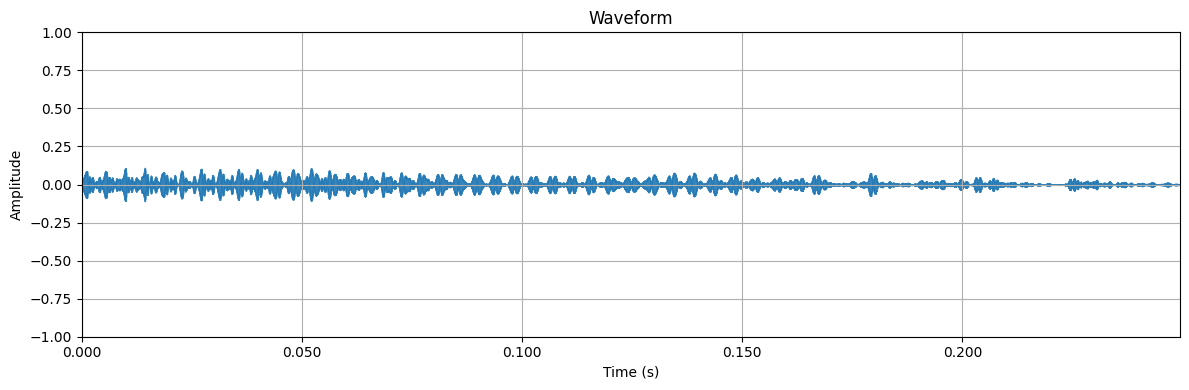

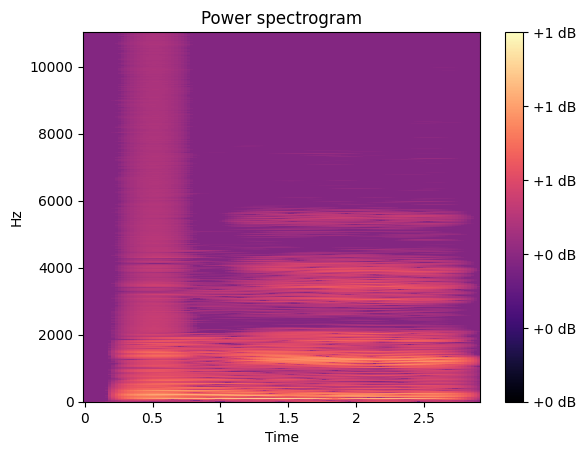

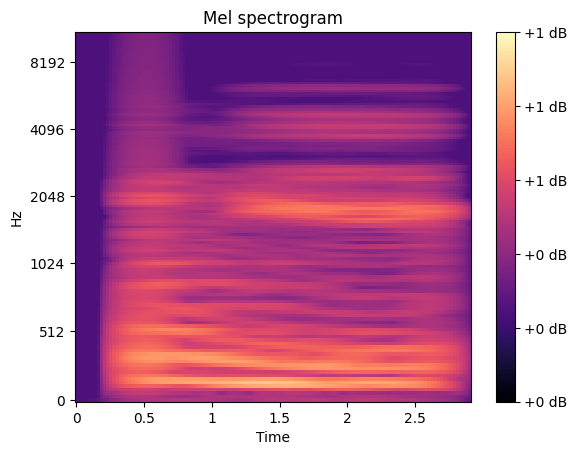

In [82]:
# check normalized data and original waveform
seed = random.randint(0,len(meta_data))
sample = meta_data.iloc[seed]
print(sample['syllable_pinyin'])
sound,sr = ap.load_file(padded_wav_path)
ap.visualize_waveform(sound, sr)
spectrogram = np.load(sample['spectrogram_path'])
ap.visualize_spectrogram(spectrogram)
mel = np.load(sample['mel_path'])
ap.visualize_mel(mel)

## high/low filter

### low pass

ba1


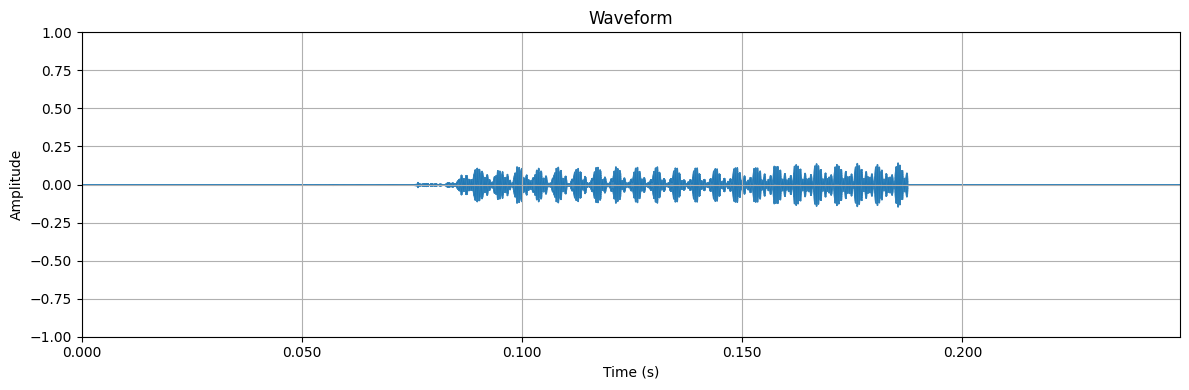

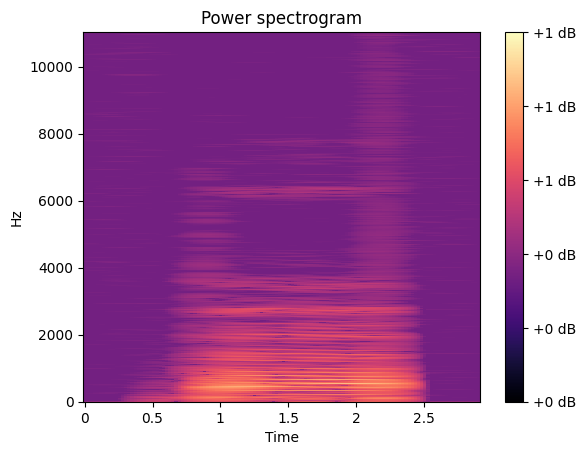

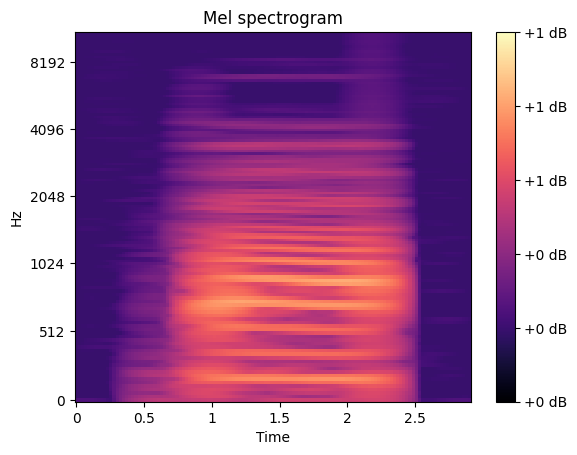

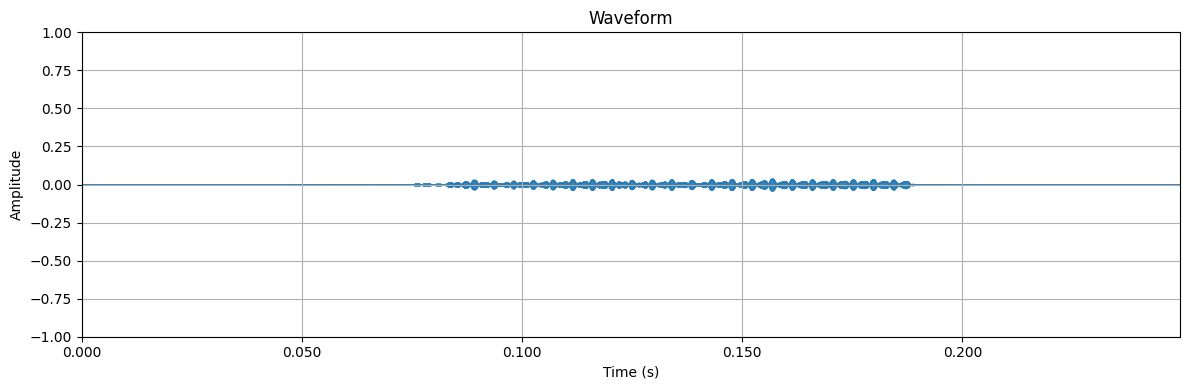

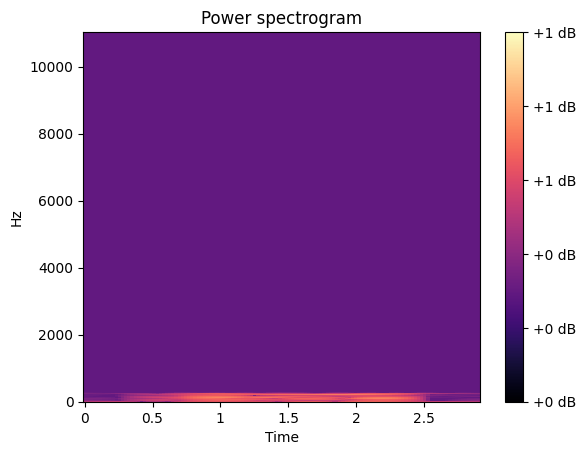

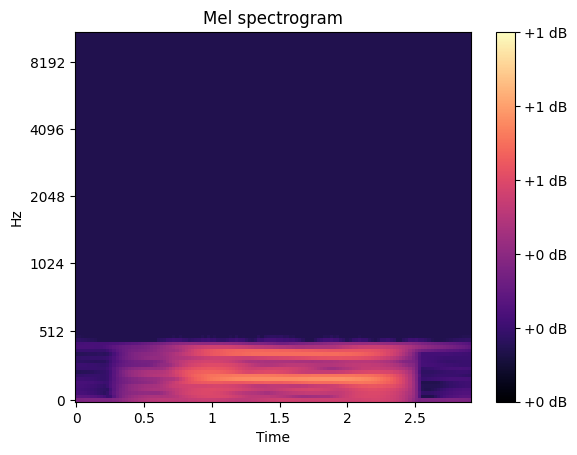

In [83]:
seed = random.randint(0,len(meta_data))
sample = meta_data.iloc[seed]
print(sample['syllable_pinyin'])
sound,sr = ap.load_file(sample['padded_wav_path'])
ap.visualize_waveform(sound, sr)
spectrogram = np.load(sample['spectrogram_path'])
ap.visualize_spectrogram(spectrogram)
mel = np.load(sample['mel_path'])
ap.visualize_mel(mel)
sound_low = ap.lowpass_filter(sound,sr,cut_off_upper=500,cut_off_lower=0)
ap.visualize_waveform(sound_low,sr)
S = ap.wav_to_spectrogram(sound_low,n_fft = int((1024/16000)*sr),hop_length = int((32/16000)*sr))
S = dp.fixed_min_max_normalization(S,min = spec_min_dB, max = spec_max_dB)
mel = ap.wav_to_mel_spectrogram(sound_low,sr = sr,n_fft = int((1024/16000)*sr),hop_length = int((32/16000)*sr))
mel = dp.fixed_min_max_normalization(mel,min = mel_min_dB, max = mel_max_dB)
ap.visualize_spectrogram(S)
ap.visualize_mel(mel)

In [84]:
meta_data['lowpass_wav_path'] = meta_data.apply(lambda row: os.path.join(lowpass_padded_waves_folder, row['speaker'],row['suid']+"_low.wav"), axis=1)
meta_data['lowpass_spectrogram_path'] = meta_data.apply(lambda row: os.path.join(lowpass_spectrogram_folder, row['speaker'],row['suid']+"_lowspec.npy"), axis=1)
meta_data['lowpass_mel_path'] = meta_data.apply(lambda row: os.path.join(lowpass_mel_folder, row['speaker'],row['suid']+"_lowmel.npy"), axis=1)
print(meta_data['lowpass_wav_path'][4])
print(meta_data['lowpass_spectrogram_path'][4])
print(meta_data['lowpass_mel_path'][4])
meta_data.to_csv(meta_path,index =False)

/mnt/storage/compling/proslearn/src/man_tone/train/lowpass_padded_wavs/SSB0005/SSB00050001_5_xue2_low.wav
/mnt/storage/compling/proslearn/src/man_tone/train/lowpass_spectrograms/SSB0005/SSB00050001_5_xue2_lowspec.npy
/mnt/storage/compling/proslearn/src/man_tone/train/lowpass_mels/SSB0005/SSB00050001_5_xue2_lowmel.npy


In [ ]:
for index,sample in meta_data.iterrows():
    if index % 5000 == 0:
        print(index)
    sound,sr = ap.load_file(sample['padded_wav_path'])
    sound_low = ap.lowpass_filter(sound,sr,cut_off_upper=500,cut_off_lower=0)
    lowpass_subfolder = os.path.dirname(sample['lowpass_wav_path'])
    if os.path.exists(lowpass_subfolder) is False:
        os.makedirs(lowpass_subfolder)
    if os.path.exists(sample['lowpass_wav_path']) is False:
        sf.write(file = sample['lowpass_wav_path'],data=sound_low,samplerate= sr)
    spectrogram = ap.wav_to_spectrogram(sound_low,n_fft = int((1024/16000)*sr),hop_length = int((32/16000)*sr))
    spectrogram = dp.fixed_min_max_normalization(spectrogram,min = spec_min_dB, max = spec_max_dB)
    mel = ap.wav_to_mel_spectrogram(sound_low,sr = sr,n_fft = int((1024/16000)*sr),hop_length = int((32/16000)*sr))
    mel = dp.fixed_min_max_normalization(mel,min = mel_min_dB, max = mel_max_dB)
    spec_subfolder = os.path.dirname(sample['lowpass_spectrogram_path'])
    if os.path.exists(spec_subfolder) is False:
        os.makedirs(spec_subfolder)
    
    mel_subfolder = os.path.dirname(sample['lowpass_mel_path'])
    if os.path.exists(mel_subfolder) is False:
        os.makedirs(mel_subfolder)
    np.save(file = sample['lowpass_spectrogram_path'], arr = spectrogram)
    np.save(file = sample['lowpass_mel_path'], arr = mel)
    

0


bing4


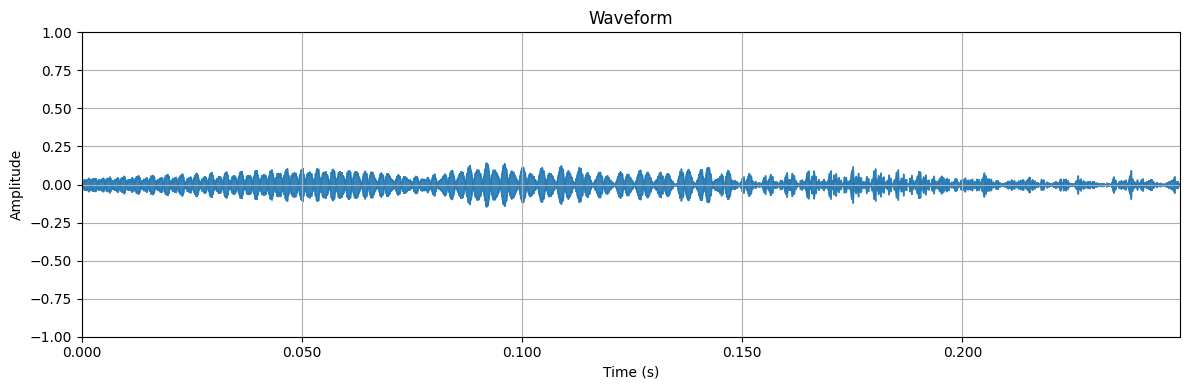

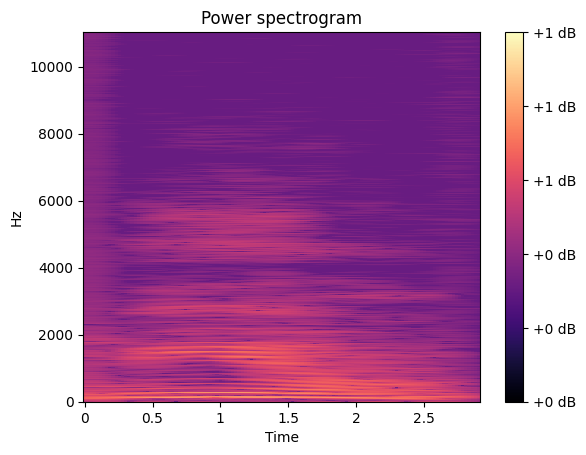

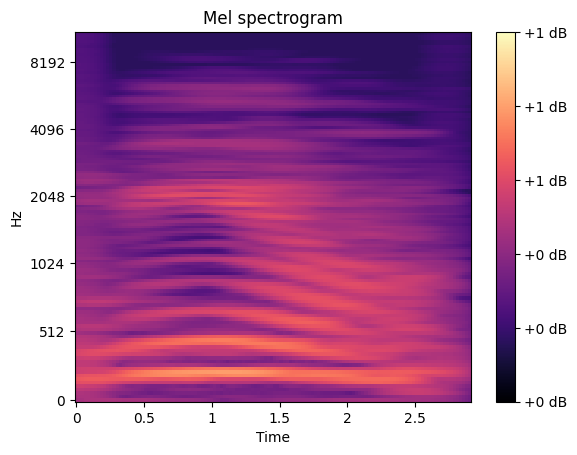

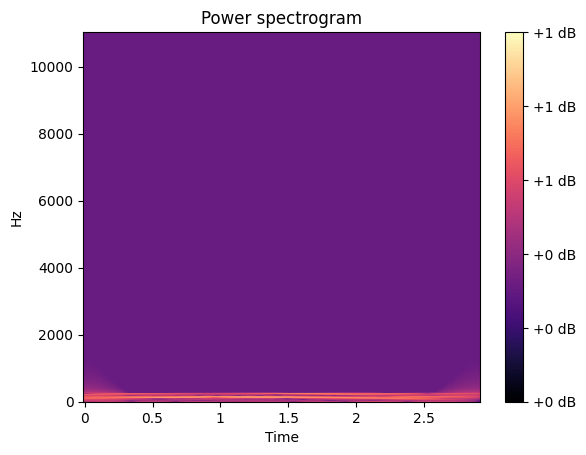

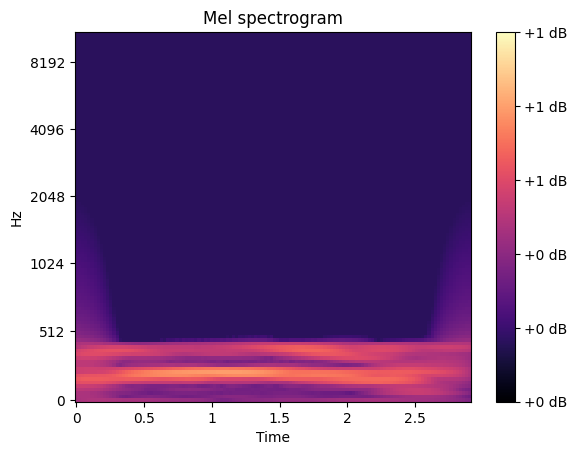

In [62]:
# check normalized data and original waveform
seed = random.randint(0,len(meta_data))
sample = meta_data.iloc[seed]
print(sample['syllable_pinyin'])
sound,sr = ap.load_file(padded_wav_path)
ap.visualize_waveform(sound, sr)
spectrogram = np.load(sample['spectrogram_path'])
ap.visualize_spectrogram(spectrogram)
mel = np.load(sample['mel_path'])
ap.visualize_mel(mel)
low_spec = np.load(sample['lowpass_spectrogram_path'])
ap.visualize_spectrogram(low_spec)
low_mel = np.load(sample['lowpass_mel_path'])
ap.visualize_mel(low_mel)

### high pass

In [42]:
meta_data['highpass_wav_path'] = meta_data.apply(lambda row: os.path.join(highpass_padded_waves_folder, row['speaker'],row['suid']+"_high.wav"), axis=1)
meta_data['highpass_spectrogram_path'] = meta_data.apply(lambda row: os.path.join(highpass_spectrogram_folder, row['speaker'],row['suid']+"_highspec.npy"), axis=1)
meta_data['highpass_mel_path'] = meta_data.apply(lambda row: os.path.join(highpass_mel_folder, row['speaker'],row['suid']+"_highmel.npy"), axis=1)
print(meta_data['highpass_wav_path'][4])
print(meta_data['highpass_spectrogram_path'][4])
print(meta_data['highpass_mel_path'][4])
meta_data.to_csv(meta_path,index =False)

/mnt/storage/compling/proslearn/src/man_tone/test/highpass_padded_wavs/SSB0693/SSB06930002_5_bei4_high.wav
/mnt/storage/compling/proslearn/src/man_tone/test/highpass_spectrograms/SSB0693/SSB06930002_5_bei4_highspec.npy
/mnt/storage/compling/proslearn/src/man_tone/test/highpass_mels/SSB0693/SSB06930002_5_bei4_highmel.npy


you3


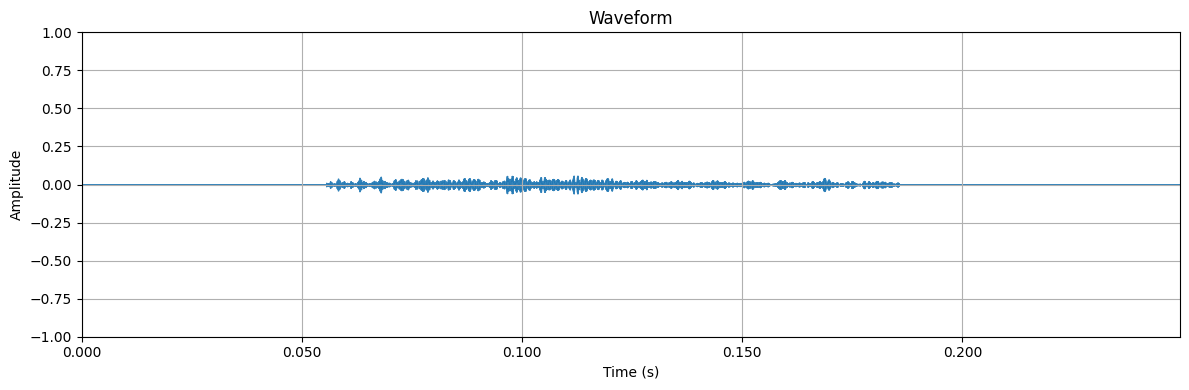

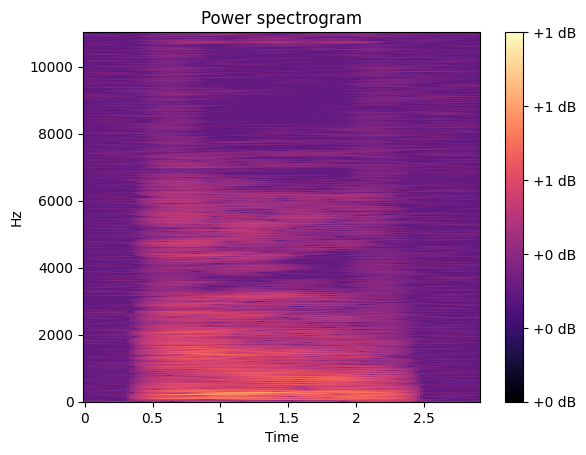

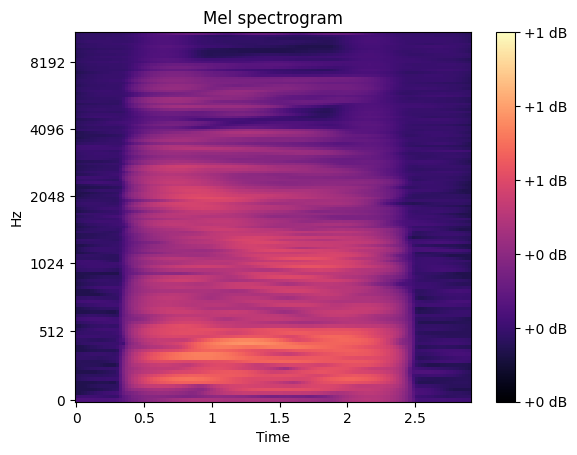

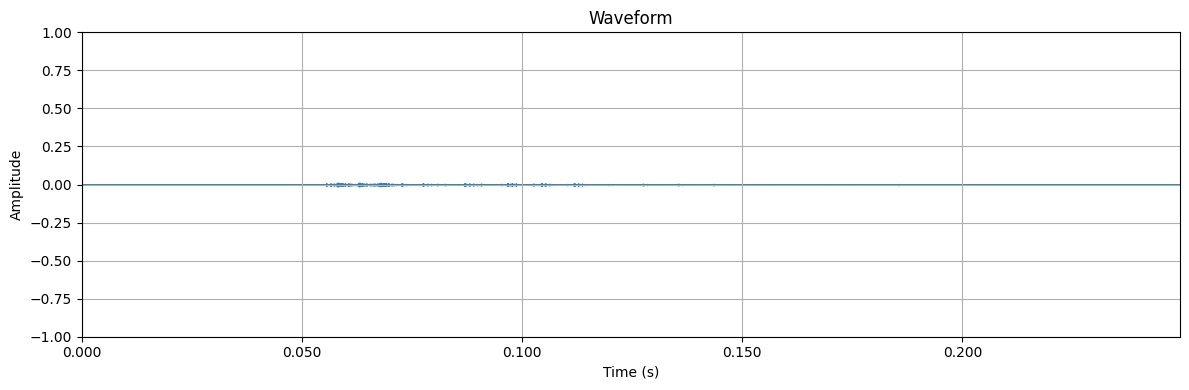

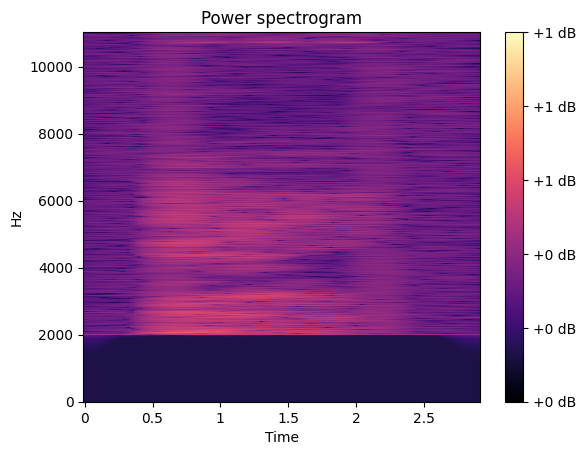

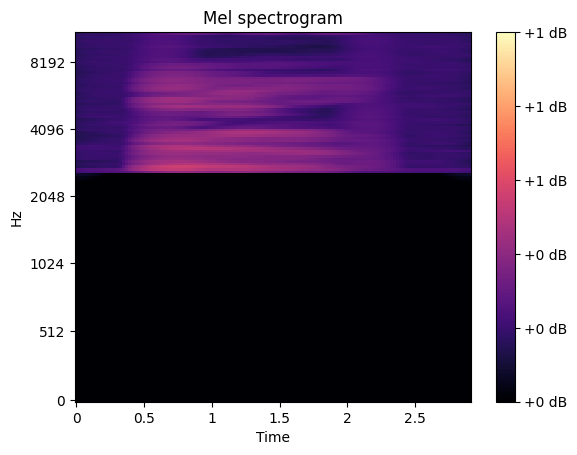

In [63]:
seed = random.randint(0,len(meta_data))
sample = meta_data.iloc[seed]
print(sample['syllable_pinyin'])
sound,sr = ap.load_file(sample['padded_wav_path'])
ap.visualize_waveform(sound, sr)
spectrogram = np.load(sample['spectrogram_path'])
ap.visualize_spectrogram(spectrogram)
mel = np.load(sample['mel_path'])
ap.visualize_mel(mel)
sound_high= ap.lowpass_filter(sound,sr,cut_off_upper=int(sr/2),cut_off_lower=4000)
ap.visualize_waveform(sound_high,sr)
S = ap.wav_to_spectrogram(sound_high,n_fft = int((1024/16000)*sr),hop_length = int((32/16000)*sr))
S = dp.fixed_min_max_normalization(S,min = spec_min_dB, max = spec_max_dB)
mel = ap.wav_to_mel_spectrogram(sound_high,sr = sr,n_fft = int((1024/16000)*sr),hop_length = int((32/16000)*sr))
mel = dp.fixed_min_max_normalization(mel,min = mel_min_dB, max = mel_max_dB)
ap.visualize_spectrogram(S)
ap.visualize_mel(mel)

In [64]:
for index,sample in meta_data.iterrows():
    if index % 5000 == 0:
        print(index)
    sound, sr = ap.load_file(sample['padded_wav_path'])
    sound_high = ap.lowpass_filter(sound,sr,cut_off_upper=int(sr/2),cut_off_lower=4000)
    highpass_subfolder = os.path.dirname(sample['highpass_wav_path'])
    if os.path.exists(highpass_subfolder) is False:
        os.makedirs(highpass_subfolder)
    sf.write(file=sample['highpass_wav_path'], data=sound_high, samplerate=sr)
    spectrogram = ap.wav_to_spectrogram(sound_high,n_fft = int((1024/16000)*sr),hop_length = int((32/16000)*sr))
    spectrogram = dp.fixed_min_max_normalization(spectrogram, min=spec_min_dB, max=spec_max_dB)
    mel = ap.wav_to_mel_spectrogram(sound_high,sr = sr,n_fft = int((1024/16000)*sr),hop_length = int((32/16000)*sr))
    mel = dp.fixed_min_max_normalization(mel, min=mel_min_dB, max=mel_max_dB)
    spec_subfolder = os.path.dirname(sample['highpass_spectrogram_path'])
    if os.path.exists(spec_subfolder) is False:
        os.makedirs(spec_subfolder)

    mel_subfolder = os.path.dirname(sample['highpass_mel_path'])
    if os.path.exists(mel_subfolder) is False:
        os.makedirs(mel_subfolder)
    np.save(file=sample['highpass_spectrogram_path'], arr=spectrogram)
    np.save(file=sample['highpass_mel_path'], arr=mel)

0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000
95000
100000
105000
110000
115000
120000
125000
130000
135000
140000
145000
150000
155000
160000
165000
170000
175000
180000
185000
190000
195000
200000
205000
210000
215000
220000
225000
230000
235000
240000
245000
250000
255000
260000


tai2


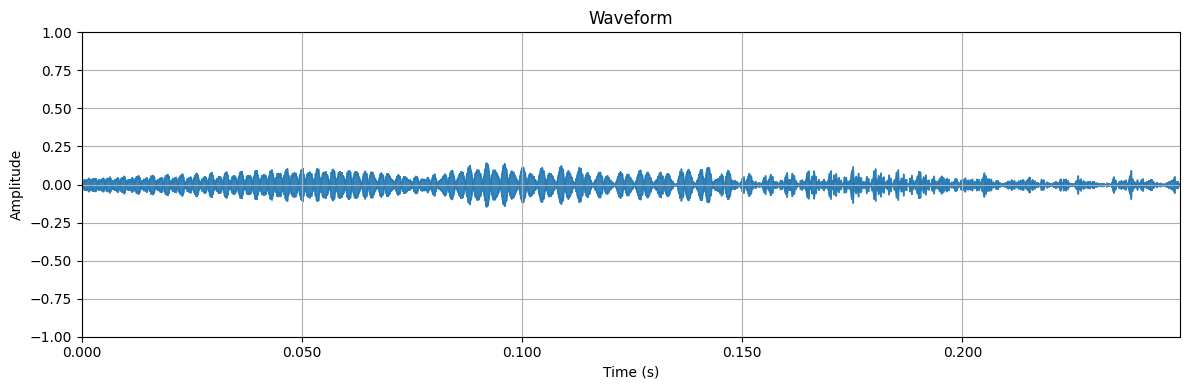

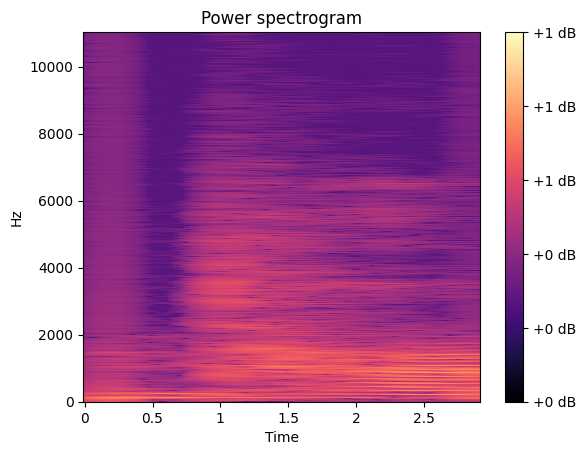

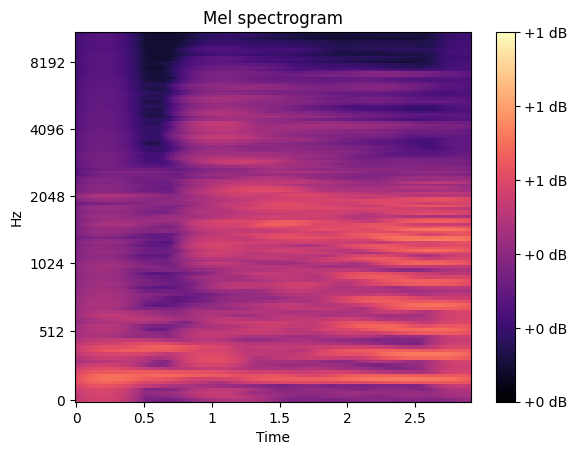

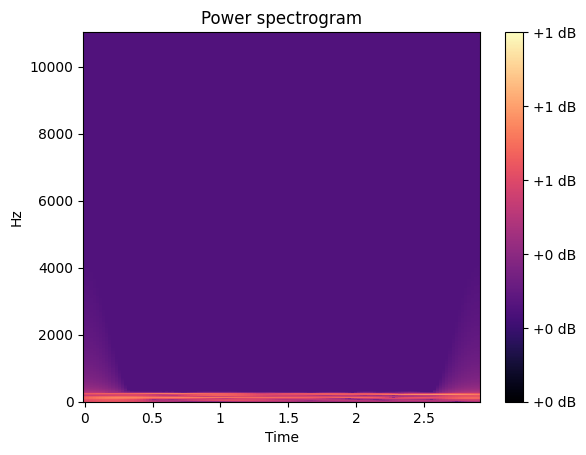

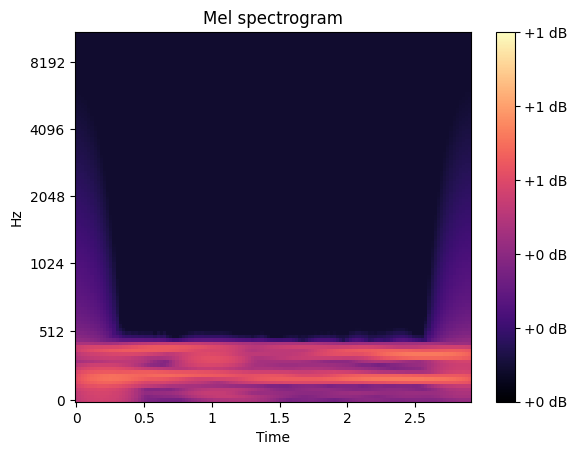

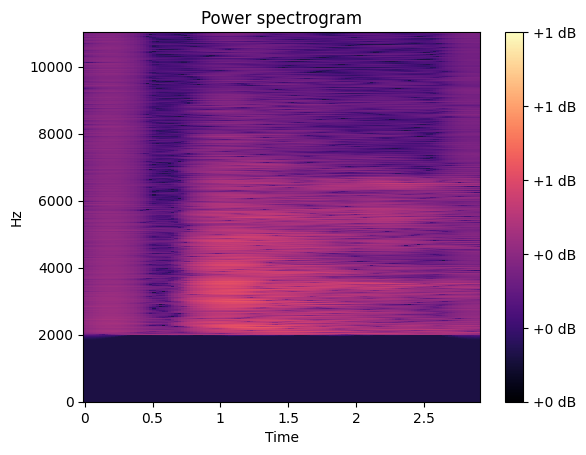

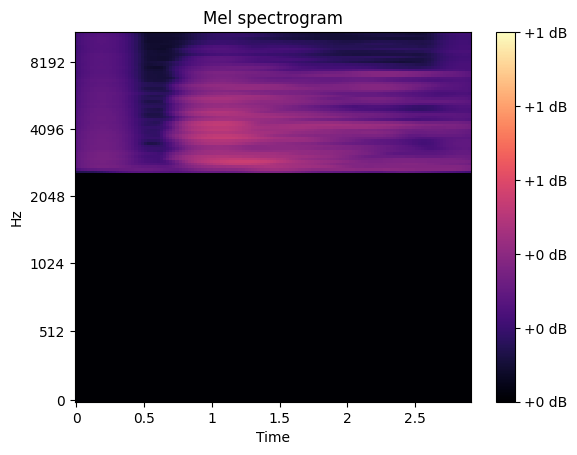

In [65]:
# check normalized data and original waveform
seed = random.randint(0,len(meta_data))
sample = meta_data.iloc[seed]
print(sample['syllable_pinyin'])
sound,sr = ap.load_file(padded_wav_path)
ap.visualize_waveform(sound, sr)
spectrogram = np.load(sample['spectrogram_path'])
ap.visualize_spectrogram(spectrogram)
mel = np.load(sample['mel_path'])
ap.visualize_mel(mel)
low_spec = np.load(sample['lowpass_spectrogram_path'])
ap.visualize_spectrogram(low_spec)
low_mel = np.load(sample['lowpass_mel_path'])
ap.visualize_mel(low_mel)
high_spec = np.load(sample['highpass_spectrogram_path'])
ap.visualize_spectrogram(high_spec)
high_mel = np.load(sample['highpass_mel_path'])
ap.visualize_mel(high_mel)

In [66]:
dp.save_dataset(meta_data,os.path.join("/mnt/storage/compling/proslearn/src/man_tone",f"meta_{set}.pkl"))

# Load dataset

In [2]:

# meta data file (with syllable information)
import PretermDataLoader as dl
import audioPreprocess as ap
import random
import dataPreprocess as dp

metafile = '/mnt/storage/compling/proslearn/src/man_tone/meta_test.pkl'
datanum = 10000 # assume that you want 10000 tokens

loader = dl.DataLoader()
meta = loader.get_metadata(metafile)

In [4]:
meta["stress_type"]

0         3
1         4
2         3
3         1
4         4
         ..
260118    1
260119    3
260120    2
260121    1
260122    3
Name: stress_type, Length: 260123, dtype: int64

In [ ]:
import pandas as pd
import numpy as np

# Mock data creation
def create_mock_data():
    # Metadata
    meta_data = {
        "id": [1, 2, 3, 4, 5],
        "stress_type": ["type1", "type2", "type1", "type3", "type2"],
        "other_info": [100, 200, 300, 400, 500]
    }
    meta_file = pd.DataFrame(meta_data)

    # NumPy data corresponding to metadata
    data = np.array([
        [1.0, 2.0, 3.0],
        [4.0, 5.0, 6.0],
        [7.0, 8.0, 9.0],
        [10.0, 11.0, 12.0],
        [13.0, 14.0, 15.0]
    ])  # Shape (5, 3)

    return meta_file, data

# Test filtering logic
def test_filtering_alignment():
    # Create mock data
    meta_file, data = create_mock_data()

    # Define a filter function
    def filter_fn(meta_file):
        return meta_file["stress_type"].isin(["type1", "type2"])  # Keep only rows with "type1" and "type2"

    # Save original indices
    original_indices = meta_file.index

    # Apply the filter function to the metadata
    filtered_meta_file = meta_file[filter_fn(meta_file)]

    # Get filtered indices
    filtered_indices = filtered_meta_file.index

    # Apply the same filtering to the NumPy data
    filtered_data = data[filtered_indices]

    # Assertions to verify alignment
    print("Filtered Metadata:\n", filtered_meta_file)
    print("Filtered Data:\n", filtered_data)
    
    # Check the number of rows match
    assert len(filtered_meta_file) == filtered_data.shape[0], "Mismatch in filtered metadata and data sizes"

    listified_stress_types = filtered_meta_file["stress_type"].tolist()
    print("Filtered Stress Types:", listified_stress_types)

    for i in range(len(listified_stress_types)):
        print("Row", i, ":", listified_stress_types[i], "Data:", filtered_data[i])

# Run the test
test_filtering_alignment()

# NOTE: after test, we found that this method should be correct. 


Filtered Metadata:
    id stress_type  other_info
0   1       type1         100
1   2       type2         200
2   3       type1         300
4   5       type2         500
Filtered Data:
 [[ 1.  2.  3.]
 [ 4.  5.  6.]
 [ 7.  8.  9.]
 [13. 14. 15.]]
Filtered Stress Types: ['type1', 'type2', 'type1', 'type2']
Row 0 : type1 Data: [1. 2. 3.]
Row 1 : type2 Data: [4. 5. 6.]
Row 2 : type1 Data: [7. 8. 9.]
Row 3 : type2 Data: [13. 14. 15.]


/mnt/storage/compling/proslearn/src/data_construction/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


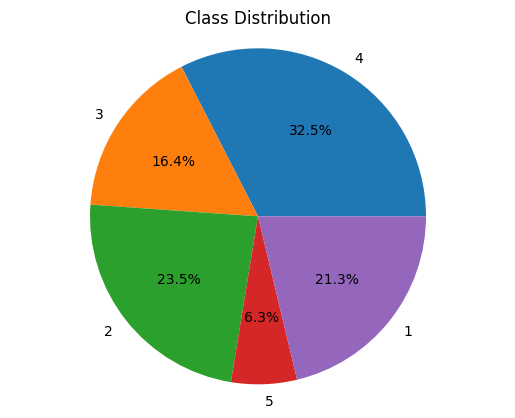

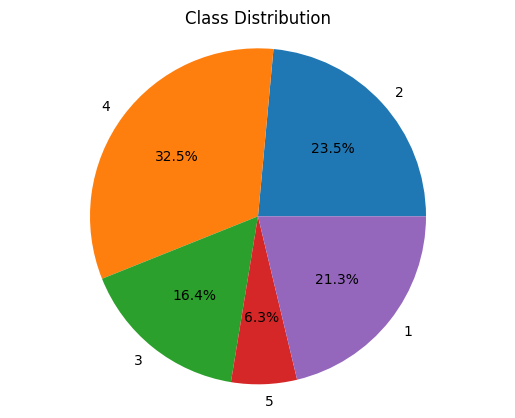

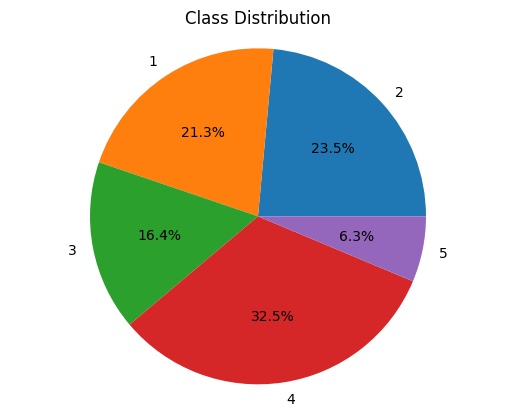

In [53]:
# you can get a bunch of indexlists that keeps the original distribution first
meta['index'] = meta.index
indexset = meta[['stress_type','index','suid']]
# Split into subsets
subsets_index = dp.split_into_subsets(indexset, num_subsets=3, sortkey='stress_type')
#Display the resulting subsets
for i, subset in enumerate(subsets_index):
    dp.checkDistribution(subset['stress_type'])

syllable: yue1; tone_type:1; suid:SSB19020026_9_yue1


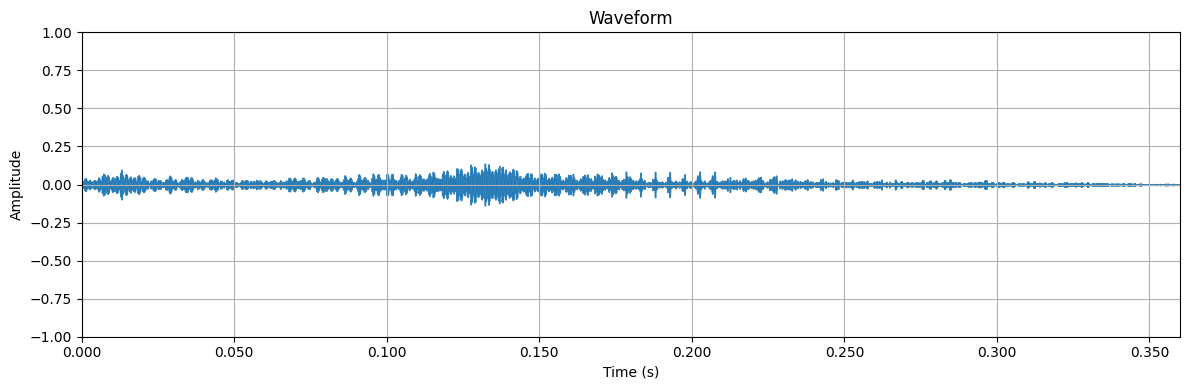

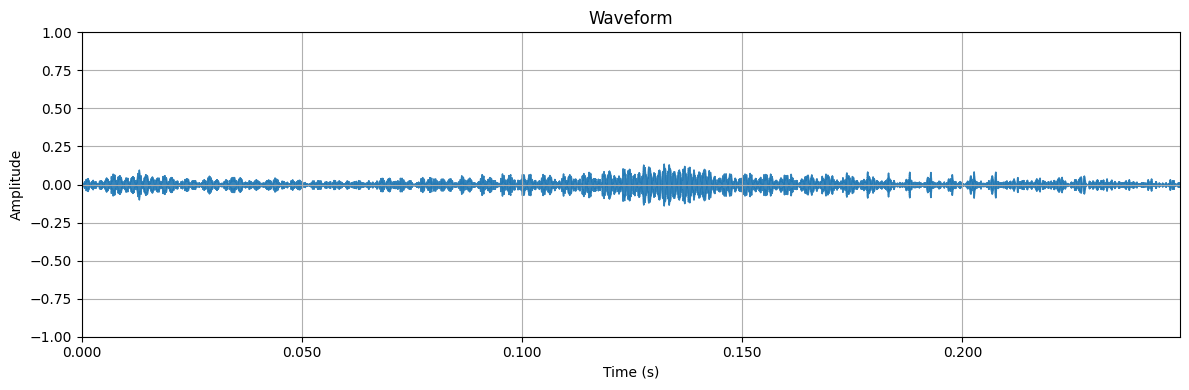

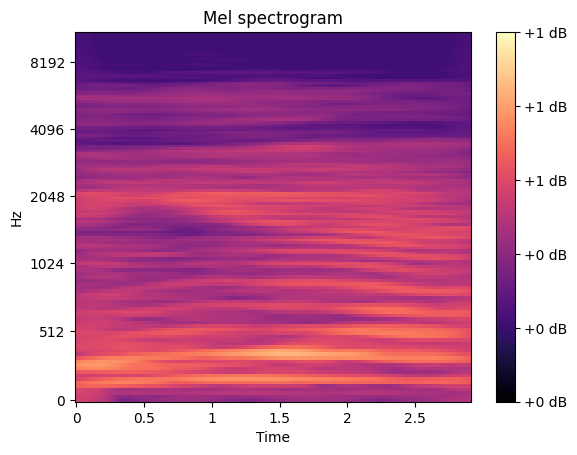

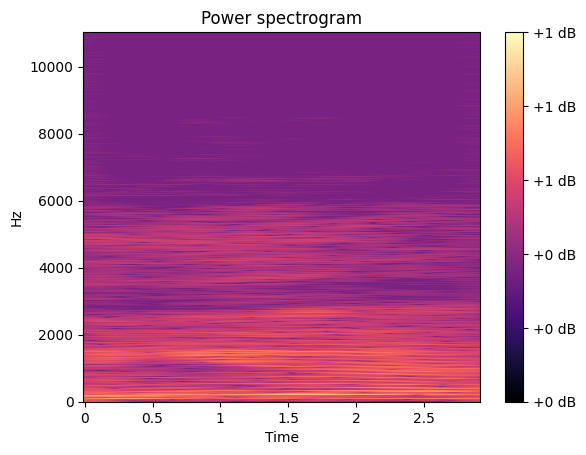

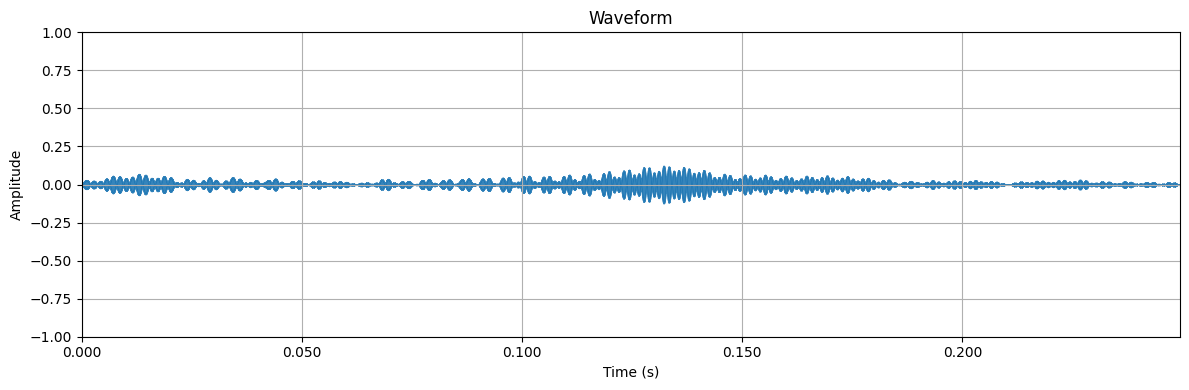

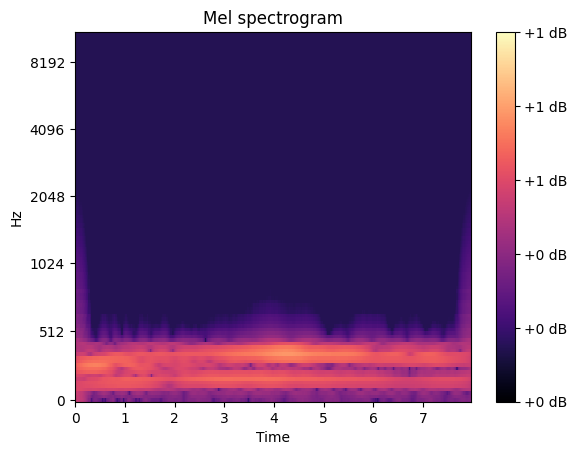

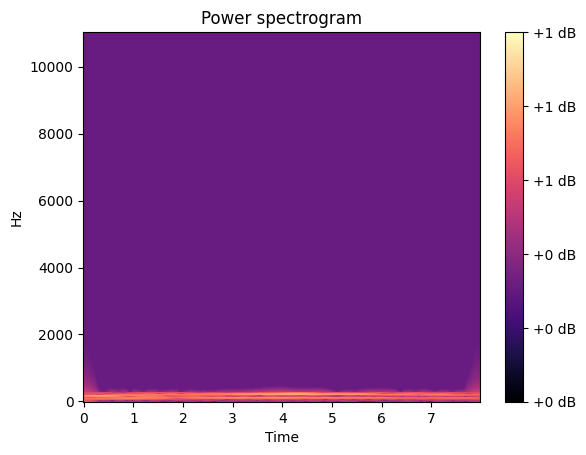

In [59]:
seed = random.randint(0,datanum)
indexes = subsets_index[0]
index = indexes['index'].iloc[seed]
syllble = meta['syllable_pinyin'][index]
suid = meta['suid'][index]
tone_type = meta['tone_type'][index]
print(f'syllable: {syllble}; tone_type:{tone_type}; suid:{suid}')
sound,sr = ap.load_file(meta['syllable_path'][index])
ap.visualize_waveform(sound,sr)
padded,sr = ap.load_file(meta['padded_wav_path'][index])
ap.visualize_waveform(padded,sr)
mel = np.load(meta['mel_path'][index])
ap.visualize_mel(mel)
spectrogram = np.load(meta['spectrogram_path'][index])
ap.visualize_spectrogram(spectrogram)
low,sr = ap.load_file(meta['lowpass_wav_path'][index])
ap.visualize_waveform(low,sr)
low_mel = np.load(meta['lowpass_mel_path'][index])
ap.visualize_mel(low_mel)
low_spectrogram = np.load(meta['lowpass_spectrogram_path'][index])
ap.visualize_spectrogram(low_spectrogram)